In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/niyarrbarman/landslide-divided")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/niyarrbarman/landslide-divided


100%|██████████| 54.9M/54.9M [00:04<00:00, 14.1MB/s]


In [3]:
!pip install transformers

In [4]:
import os
import tensorflow as tf
from tensorflow.keras import backend
import matplotlib.pyplot as plt

In [5]:
def load_image_file(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    image = tf.image.decode_jpeg(image, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    return {"image": image, "segmentation_mask": mask}

In [7]:
train_image_dir = "/content/landslide-divided/dataset/train/images"
train_mask_dir = "/content/landslide-divided/dataset/train/masks"
valid_image_dir = "/content/landslide-divided/dataset/validation/images"
valid_mask_dir = "/content/landslide-divided/dataset/validation/masks"
test_image_dir = "/content/landslide-divided/dataset/test/images"
test_mask_dir = "/content/landslide-divided/dataset/test/masks"

# Define list of image and mask file names
train_image_names = sorted(os.listdir(train_image_dir))
train_mask_names = sorted(os.listdir(train_mask_dir))

valid_image_names = sorted(os.listdir(valid_image_dir))
valid_mask_names = sorted(os.listdir(valid_mask_dir))

test_image_names = sorted(os.listdir(test_image_dir))
test_mask_names = sorted(os.listdir(test_mask_dir))

train_pairs = []
for img_name in train_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in train_mask_names:
        train_pairs.append((os.path.join(train_image_dir, img_name), os.path.join(train_mask_dir, mask_name)))

valid_pairs = []
for img_name in valid_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in valid_mask_names:
        valid_pairs.append((os.path.join(valid_image_dir, img_name), os.path.join(valid_mask_dir, mask_name)))

test_pairs = []
for img_name in test_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in test_mask_names:
        test_pairs.append((os.path.join(test_image_dir, img_name), os.path.join(test_mask_dir, mask_name)))

# Load image and mask data from file paths
data_train = [load_image_file(image_path, mask_path) for image_path, mask_path in train_pairs]
data_valid = [load_image_file(image_path, mask_path) for image_path, mask_path in valid_pairs]
data_test = [load_image_file(image_path, mask_path) for image_path, mask_path in test_pairs]

len(data_train), len(data_valid), len(data_test)

(1385, 396, 199)

In [8]:
image_size = 256
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = input_mask / 255
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))

    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [9]:
train_data = [load_image(datapoint) for datapoint in data_train]
valid_data = [load_image(datapoint) for datapoint in data_valid]
test_data = [load_image(datapoint) for datapoint in data_test]

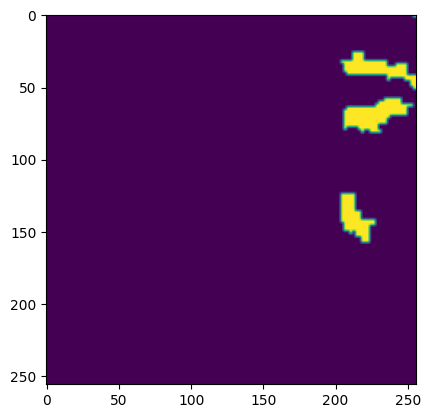

In [10]:
plt.imshow(train_data[0]["labels"])

In [11]:
def generator_train():
    for datapoint in train_data:
        yield datapoint

def generator_valid():
    for datapoint in valid_data:
        yield datapoint

def generator_test():
    for datapoint in test_data:
        yield datapoint

In [12]:
batch_size = 4
auto = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_generator(generator_train, output_types={"pixel_values": tf.float32, "labels": tf.int32}).cache().shuffle(batch_size * 10).batch(batch_size).prefetch(auto)

valid_ds = tf.data.Dataset.from_generator(generator_valid, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)

test_ds = tf.data.Dataset.from_generator(generator_test, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)

In [13]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'labels': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)}


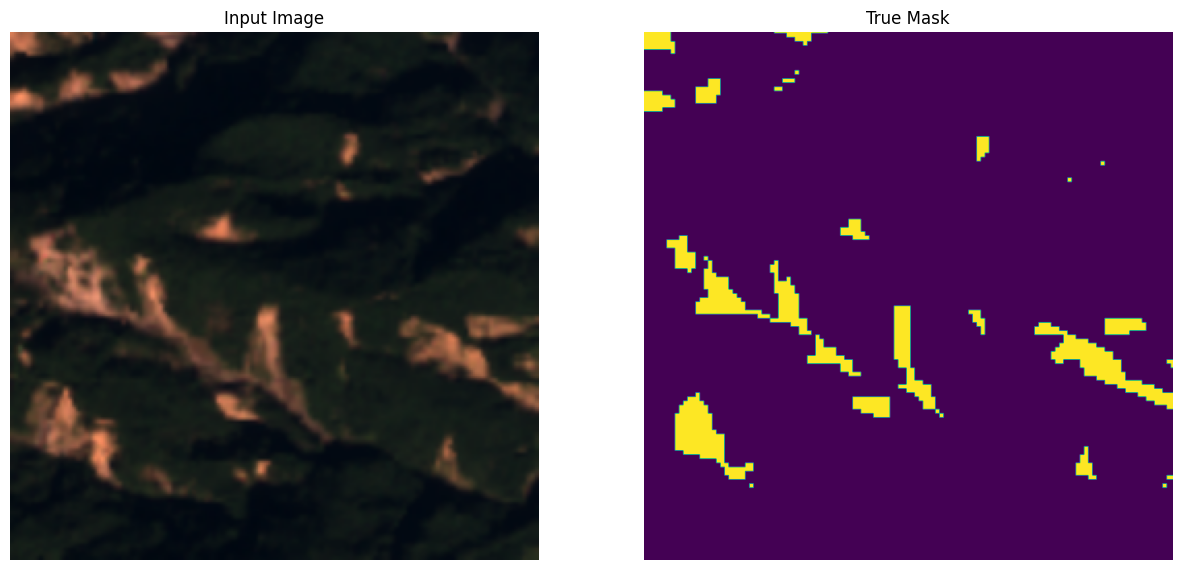

(256, 256, 3)


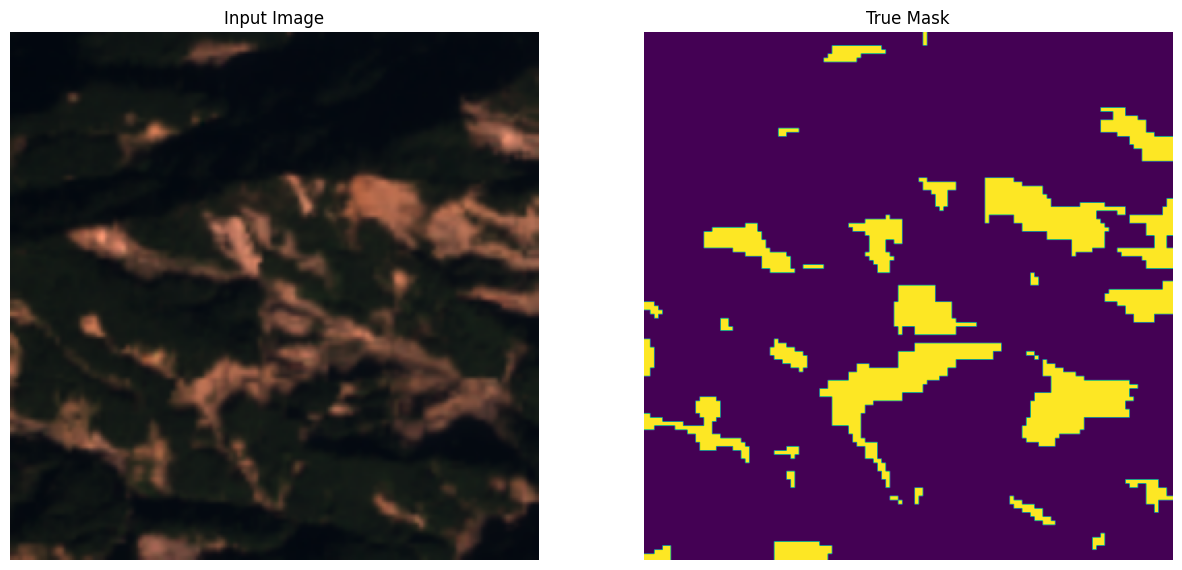

(256, 256, 3)


In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])
    print(sample_image.shape)

In [15]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b1"
id2label =  {0: "outer", 1: "landslide"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,

)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Some layers from the model checkpoint at nvidia/mit-b1 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
lr = 0.00006
epochs = 5
# Use the string identifier 'adam' instead of an optimizer instance
optimizer = 'adam'
model.compile(optimizer=optimizer)

In [19]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


1/1 [==============================] - 0s 43ms/step


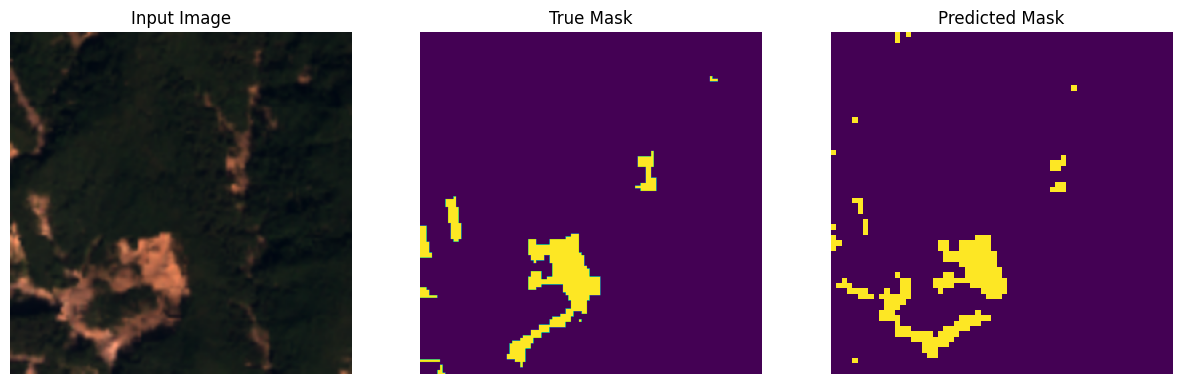


Sample Prediction after epoch 5

347/347 [==============================] - 27s 78ms/step - loss: 0.0738 - val_loss: 0.0722


In [20]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs=epochs,
)

<ipython-input-23-2df983d90a25>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


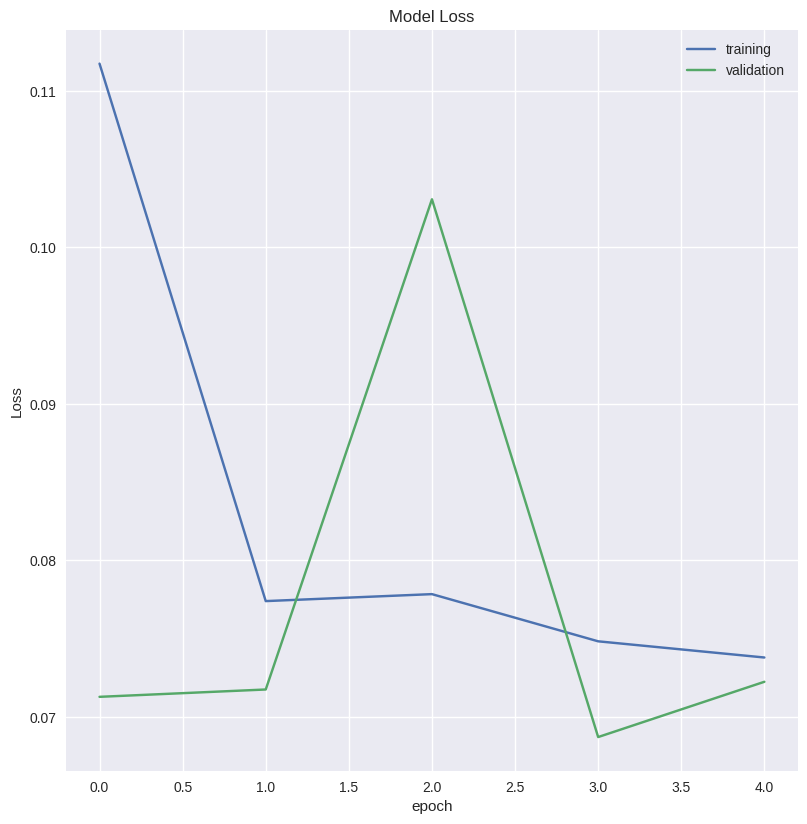

In [23]:
plt.style.use("seaborn")

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(8,8))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 111)
plt.savefig("train_eval_plot_segformer-5-b1.jpg")

1/1 [==============================] - 0s 46ms/step


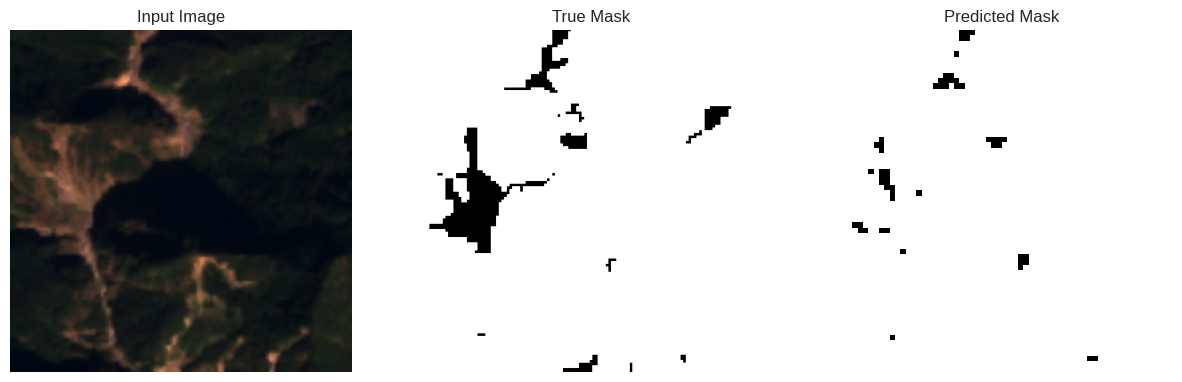

1/1 [==============================] - 0s 43ms/step


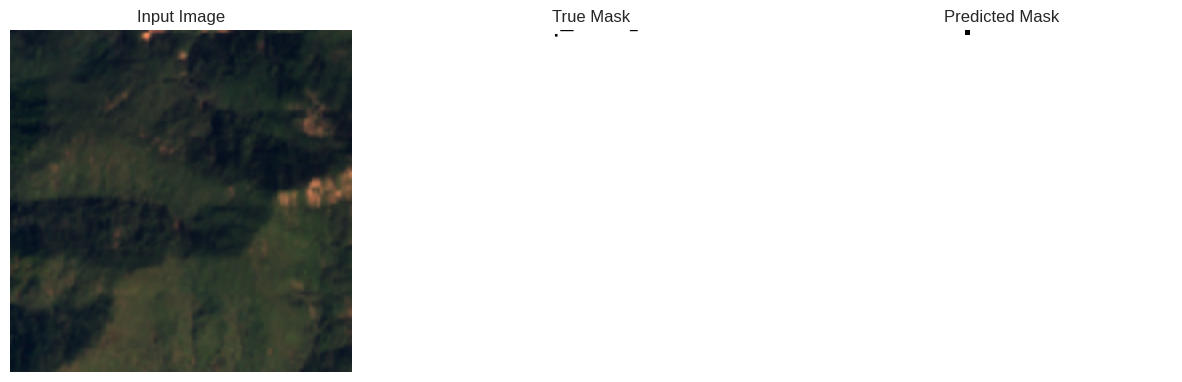

1/1 [==============================] - 0s 43ms/step


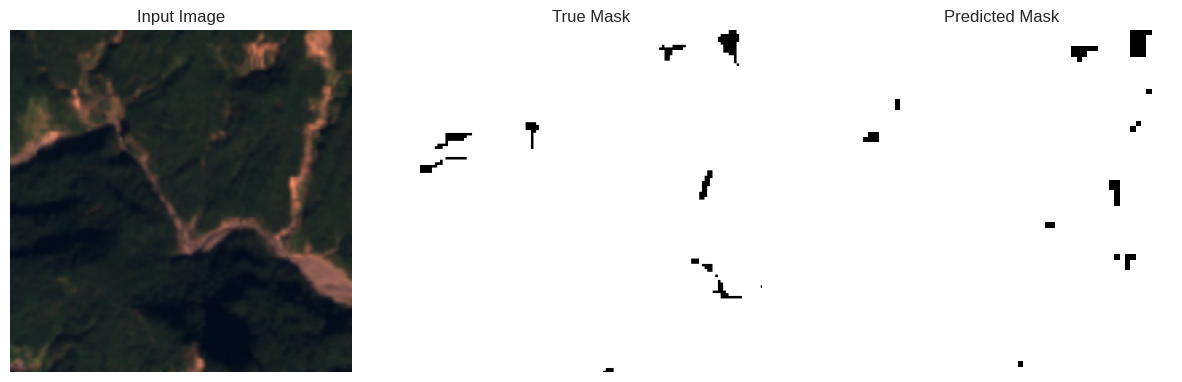

1/1 [==============================] - 0s 44ms/step


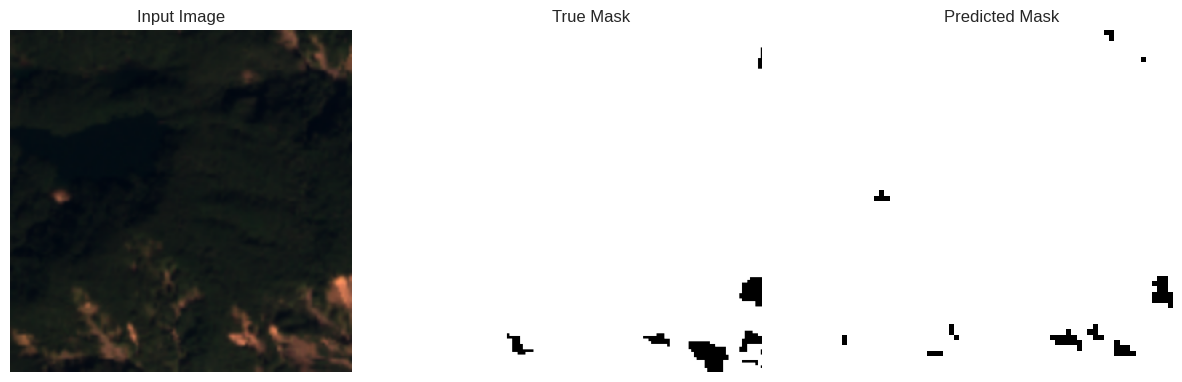

1/1 [==============================] - 0s 41ms/step


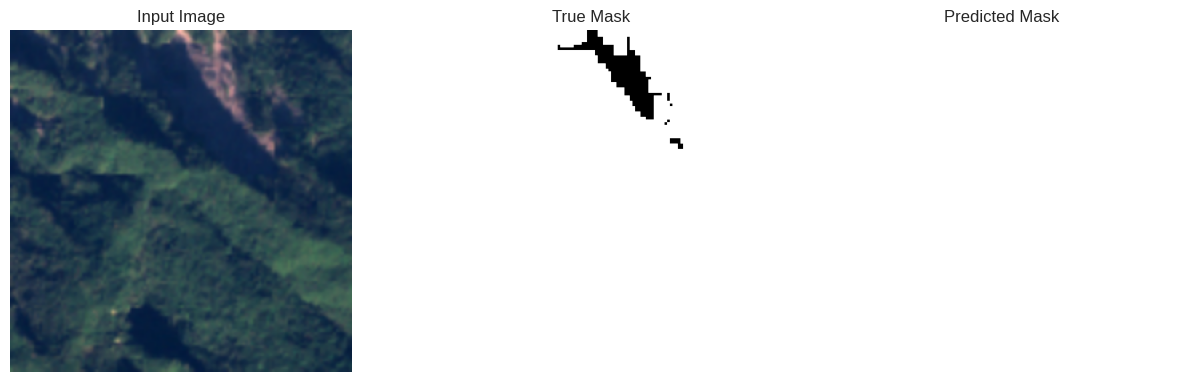

1/1 [==============================] - 0s 45ms/step


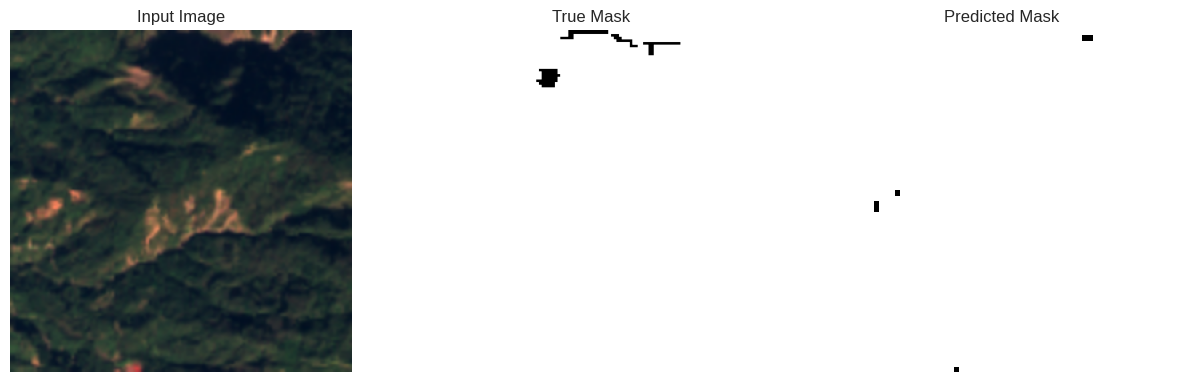

1/1 [==============================] - 0s 44ms/step


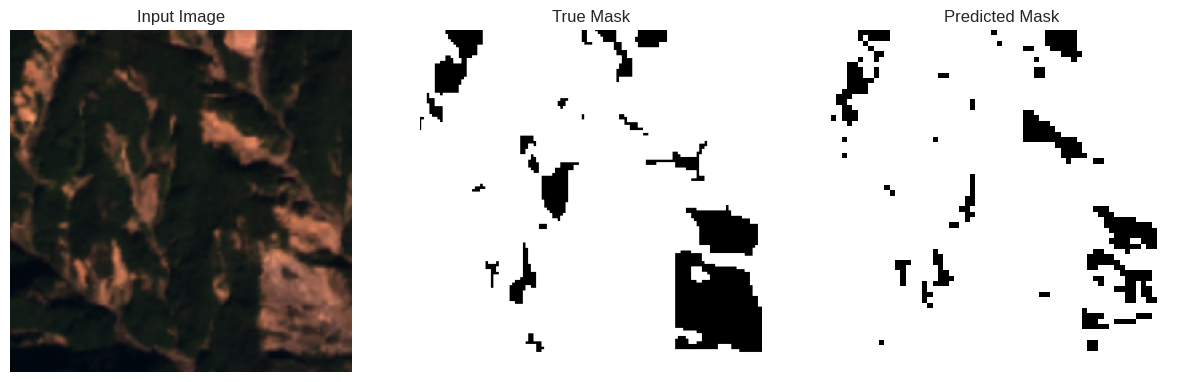

1/1 [==============================] - 0s 42ms/step


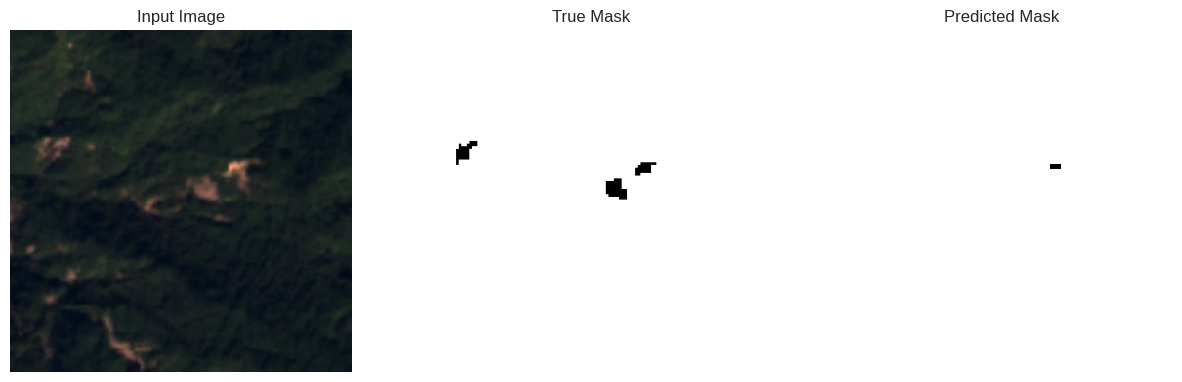

1/1 [==============================] - 0s 43ms/step


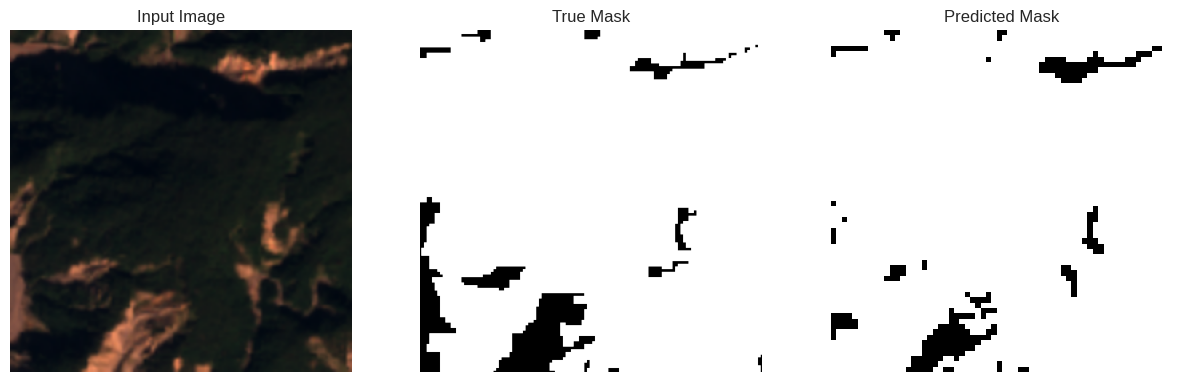

1/1 [==============================] - 0s 42ms/step


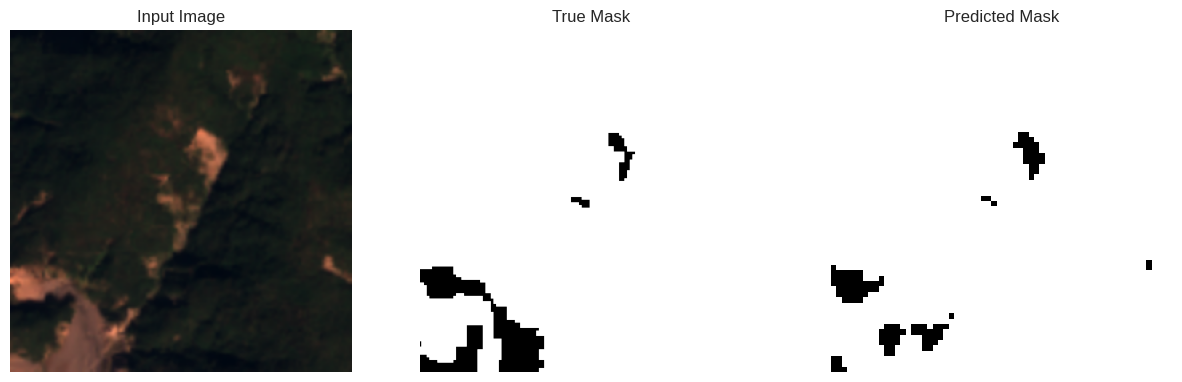

In [24]:
show_predictions(valid_ds, 10)